# Chapter 15 - Classifying Images with Deep Convolutional Neural Networks

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip freeze | grep keras

keras==2.12.0


## Implementing a deep convolutional neural network using Keras
- Example reusing the MNIST data, $n_1 \times n_2 \times c_{in} = 28 \times 28 \times 1$ (grayscale).
- $5 \times 5$ kernels, 32 and 64 output feature maps, fully connected ($1024 \times 1024$), then fully connected ($1024 \times 10$) acting as softmax (no padding)

<img src="./images/15_09.png" alt="Multilayer CNN" style="width: 1000px;"/>

## Loading and preprocessing the data

In [13]:
## unzips mnist

import sys
import gzip
import shutil
import os


if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./')
                if f.endswith('ubyte.gz')]
print(zipped_mnist)
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

[]


In [16]:
import struct
import numpy as np


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                                % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


X_data, y_data = load_mnist('/content/drive/MyDrive/Colab_Notebooks_2/data', kind='train')
print('Rows: %d,  Columns: %d' % (X_data.shape[0], X_data.shape[1]))
X_test, y_test = load_mnist('/content/drive/MyDrive/Colab_Notebooks_2/data', kind='t10k')
print('Rows: %d,  Columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train, y_train = X_data[:50000,:], y_data[:50000]
X_valid, y_valid = X_data[50000:,:], y_data[50000:]

print('Training:   ', X_train.shape, y_train.shape)
print('Validation: ', X_valid.shape, y_valid.shape)
print('Test Set:   ', X_test.shape, y_test.shape)

Rows: 60000,  Columns: 784
Rows: 10000,  Columns: 784
Training:    (50000, 784) (50000,)
Validation:  (10000, 784) (10000,)
Test Set:    (10000, 784) (10000,)


### Standardize each collection with respect to training
- Pixel-wise means
- Set-wise standard deviations (avoiding 0 division for constant pixels)

In [17]:
# Standardize data based on training data
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = (X_valid - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_data, y_data, X_train, X_valid, X_test

### Encodig and reshaping to 4D tensors

In [18]:
from sklearn.preprocessing import OneHotEncoder #, LabelEncoder
#label_encoder = LabelEncoder()
#y_encoded = label_encoder.fit_transform(y_train)
one_hot_encoder = OneHotEncoder(sparse=False, categories='auto')
Y_train = one_hot_encoder.fit_transform(y_train.reshape(-1,1))
Y_valid = one_hot_encoder.transform(y_valid.reshape(-1,1))
Y_test  = one_hot_encoder.transform(y_test.reshape(-1,1))

X_train_centered = X_train_centered.reshape((X_train_centered.shape[0], 28, 28, 1)) # Grayscale = 1
X_valid_centered = X_valid_centered.reshape((X_valid_centered.shape[0], 28, 28, 1))
X_test_centered  = X_test_centered.reshape((X_test_centered.shape[0], 28, 28, 1))
print(X_train_centered.shape)
print(Y_train.shape)

(50000, 28, 28, 1)
(50000, 10)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Set up sequential CNN model in Keras

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=[5,5], padding='valid', activation='relu', 
                 input_shape=(X_train_centered.shape[1:])))
model.add(MaxPooling2D(pool_size=[2,2], padding='same'))
model.add(Conv2D(filters=64, kernel_size=[5,5], padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], padding='same'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

In [20]:
# Requires installation of graphViz
import pydot

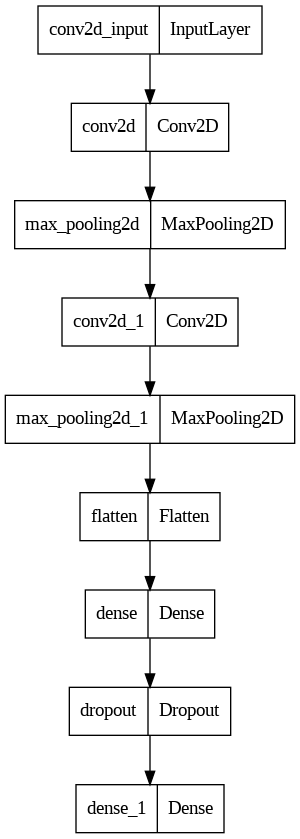

In [21]:
# !pip install pydot
from keras.utils import plot_model
plot_model(model, to_file="mod_plot.png")

### Compile model and prepare TensorBoard

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
checkpoint = ModelCheckpoint("models", save_best_only=True) #/MNIST.s

In [23]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
# To show TensorBoard, write e.g. tensorboard --logdir path_to_logdir --host 127.0.0.1 --port 80
# and navigate to 127.0.0.1 through a browser

### Training of the model
- ~1 minute per epoch on KHL's CPU

In [24]:
history = model.fit(X_train_centered, Y_train, batch_size=64, epochs=10, 
          verbose=1, shuffle=True, #          verbose=1, shuffle=True,
          validation_data=(X_valid_centered, Y_valid))#, callbacks=[checkpoint])
# A path bug in TensorFlow 2.0 makes callbacks in Windows difficult, 1.15 requires admin right first time

Epoch 1/10
782/782 [==============================] - 88s 110ms/step - loss: 0.3390 - accuracy: 0.9017 - val_loss: 0.0902 - val_accuracy: 0.9749
Epoch 2/10
782/782 [==============================] - 84s 107ms/step - loss: 0.0916 - accuracy: 0.9726 - val_loss: 0.0605 - val_accuracy: 0.9837
Epoch 3/10
782/782 [==============================] - 81s 103ms/step - loss: 0.0623 - accuracy: 0.9815 - val_loss: 0.0454 - val_accuracy: 0.9871
Epoch 4/10
782/782 [==============================] - 84s 107ms/step - loss: 0.0479 - accuracy: 0.9854 - val_loss: 0.0411 - val_accuracy: 0.9875
Epoch 5/10
782/782 [==============================] - 82s 105ms/step - loss: 0.0399 - accuracy: 0.9877 - val_loss: 0.0376 - val_accuracy: 0.9881
Epoch 6/10
782/782 [==============================] - 84s 107ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0368 - val_accuracy: 0.9895
Epoch 7/10
782/782 [==============================] - 82s 105ms/step - loss: 0.0286 - accuracy: 0.9911 - val_loss: 0.0335 - val_ac

### Plot history

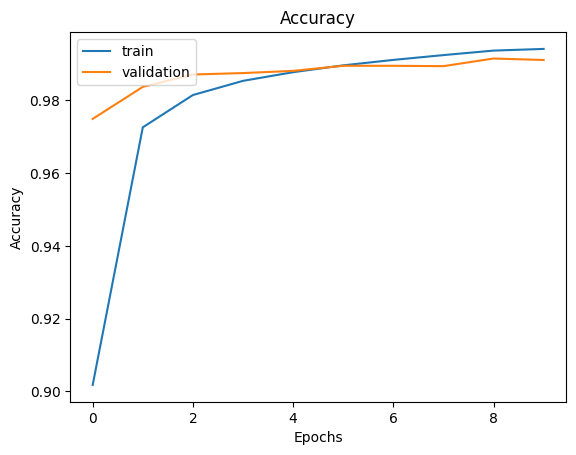

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluate on test data

In [26]:
!pwd

/content


In [ ]:
# Explicit saving of the model for later use
model.save('models/MNIST.h5')

In [27]:
# Prediction
#from tensorflow.keras.models import load_model
#model = load_model('models/MNIST.h5')
model.evaluate(X_test_centered, Y_test)

313/313 [==============================] - 4s 14ms/step - loss: 0.0233 - accuracy: 0.9923


[0.023261521011590958, 0.9922999739646912]

In [28]:
10000*(1-0.9922999739646912)

77.00026035308838

### Probabilities of each class

1/1 [==============================] - 0s 117ms/step


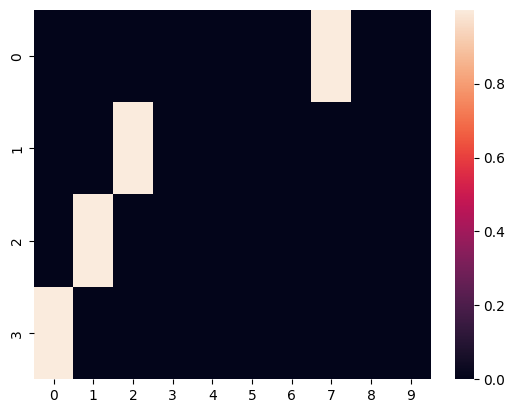

1/1 [==============================] - 0s 24ms/step


array([[1.6855333e-08, 5.6114558e-08, 1.5608933e-07, 2.1629596e-06,
        3.6598054e-11, 3.9028027e-08, 8.7742693e-13, 9.9999511e-01,
        3.4327016e-08, 2.5138647e-06],
       [7.5507927e-07, 6.6941760e-07, 9.9999821e-01, 3.0121485e-11,
        9.4250253e-11, 4.4147312e-12, 4.0301074e-08, 1.9541831e-10,
        3.7324065e-07, 3.1797891e-11],
       [4.1275403e-06, 9.9988091e-01, 6.1450828e-07, 1.6410048e-08,
        2.2992783e-05, 1.3610098e-07, 5.7644860e-07, 8.3152969e-05,
        7.0579181e-06, 3.2280008e-07],
       [9.9994385e-01, 7.1230453e-09, 3.9028947e-07, 3.8478774e-08,
        1.7545082e-07, 6.8649364e-08, 5.0406408e-05, 1.6307000e-07,
        2.8231013e-06, 2.1367539e-06]], dtype=float32)

In [29]:
# Predict with probabilities
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(model.predict(X_test_centered[:4,:]))
plt.show()
model.predict(X_test_centered[:4,:])

### Confusion matrix

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np
confusion_matrix(y_test,np.argmax(model.predict(X_test_centered), axis=1), labels = list(range(10)))

313/313 [==============================] - 5s 14ms/step


array([[ 978,    0,    0,    0,    0,    0,    0,    1,    1,    0],
       [   0, 1131,    1,    0,    0,    1,    1,    1,    0,    0],
       [   1,    2, 1025,    0,    1,    0,    0,    2,    1,    0],
       [   0,    0,    1, 1003,    0,    3,    0,    0,    3,    0],
       [   0,    0,    0,    0,  981,    0,    0,    0,    0,    1],
       [   1,    0,    0,    5,    0,  880,    1,    1,    2,    2],
       [   5,    3,    0,    1,    3,    1,  944,    0,    1,    0],
       [   1,    3,    3,    1,    0,    0,    0, 1018,    1,    1],
       [   2,    0,    2,    0,    0,    1,    0,    0,  967,    2],
       [   1,    0,    0,    1,    7,    3,    0,    0,    1,  996]])

### Activation of examples

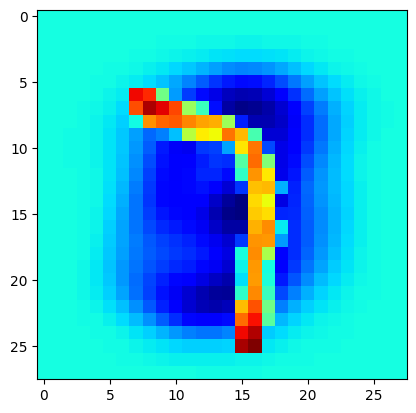

Ground truth: 7


<Figure size 4000x4000 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

In [31]:
sampleNum = 122
plt.figure()
plt.imshow(X_test_centered[sampleNum,:,:,0], interpolation='None', cmap='jet')
plt.show()
print("Ground truth: {}".format(y_test[sampleNum]))
plt.figure(figsize=(10, 10), dpi=400)

## keract 
https://github.com/philipperemy/keract

In [32]:
!pip install keract
import keract as keract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
def print_names_and_shapes(activations: dict):
    for layer_name, layer_activations in activations.items():
        print(layer_name, layer_activations.shape)
    print('-' * 80)

In [34]:
# All sizes
activations = keract.get_activations(model, X_test_centered[sampleNum:sampleNum+1])
print_names_and_shapes(activations)

conv2d_input (1, 28, 28, 1)
conv2d (1, 24, 24, 32)
max_pooling2d (1, 12, 12, 32)
conv2d_1 (1, 8, 8, 64)
max_pooling2d_1 (1, 4, 4, 64)
flatten (1, 1024)
dense (1, 1024)
dropout (1, 1024)
dense_1 (1, 10)
--------------------------------------------------------------------------------


In [35]:
keract.__version__

'4.5.1'

conv2d (1, 24, 24, 32) 


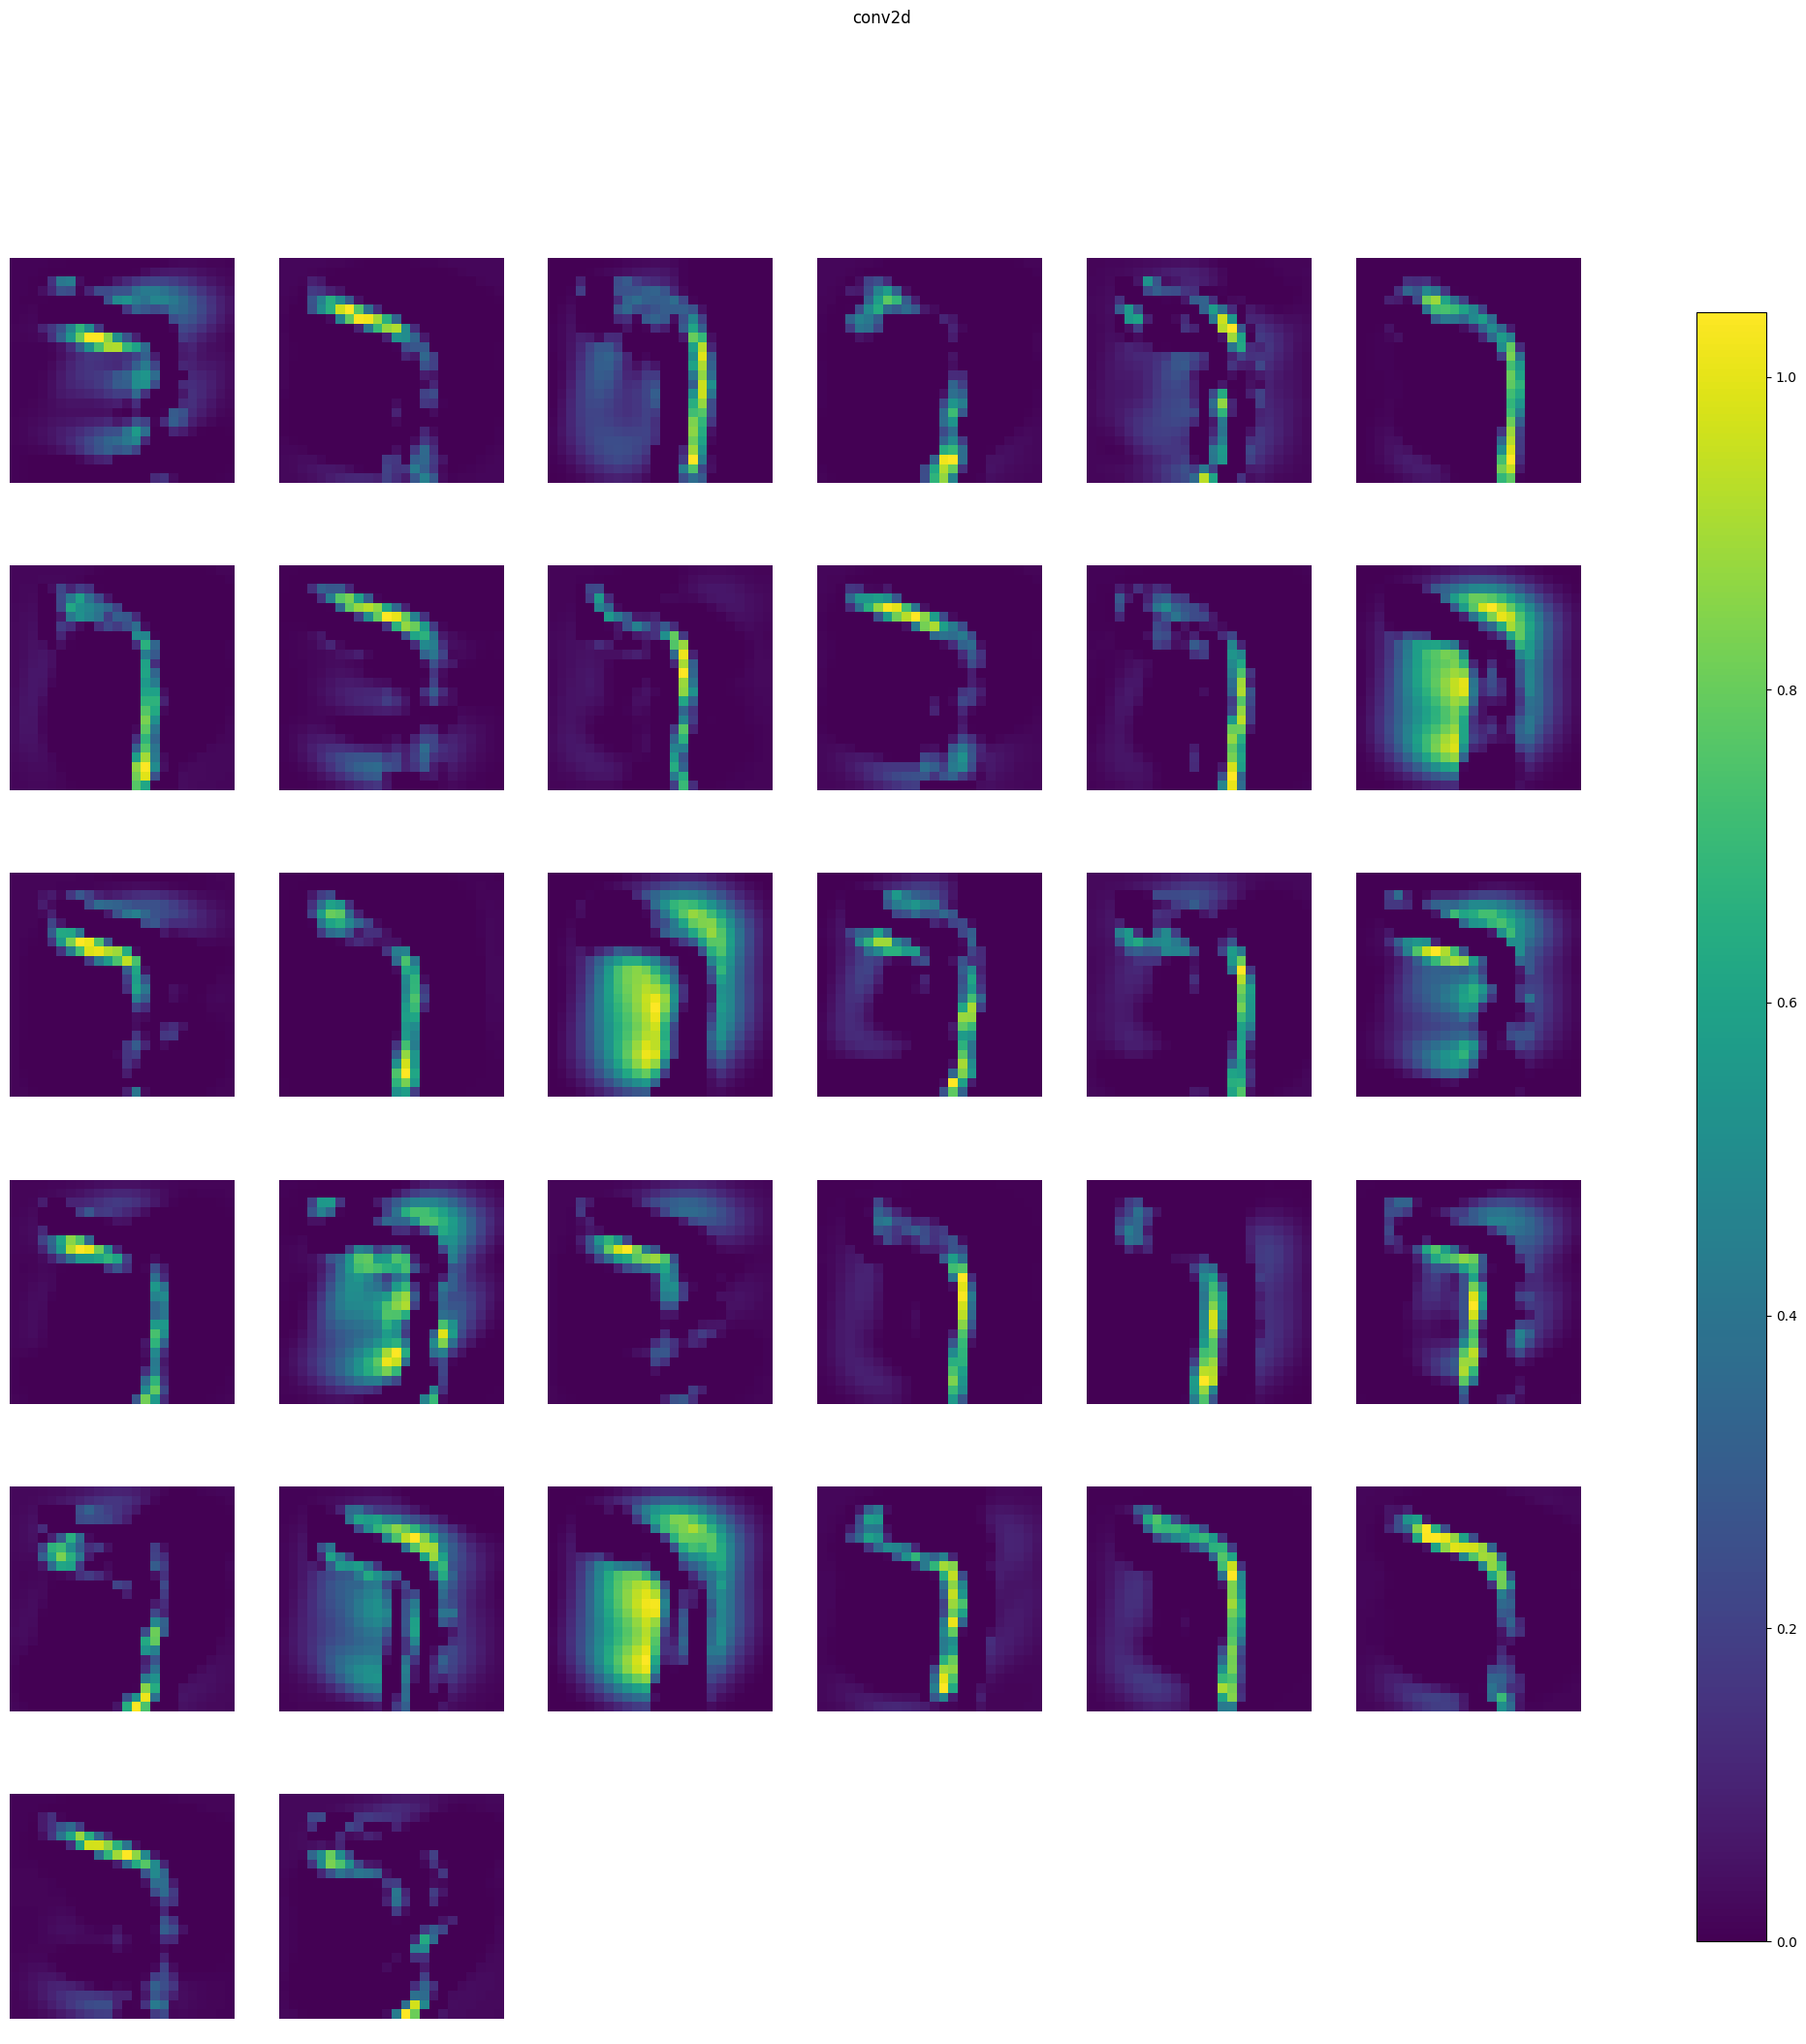

In [36]:
# Specific layer
activations = keract.get_activations(model, X_test_centered[sampleNum:sampleNum+1], layer_names='conv2d')
keract.display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(24, 24), reshape_1d_layers=False)

In [37]:
# Visualize activations
activations = keract.get_activations(model, X_test_centered[sampleNum:sampleNum+1])
# This is giving me a headache in Windows??
# keract.display_heatmaps(activations, X_test_centered[sampleNum:sampleNum+1])

### Weights from layers

(5, 5, 1, 32)


<Axes: >

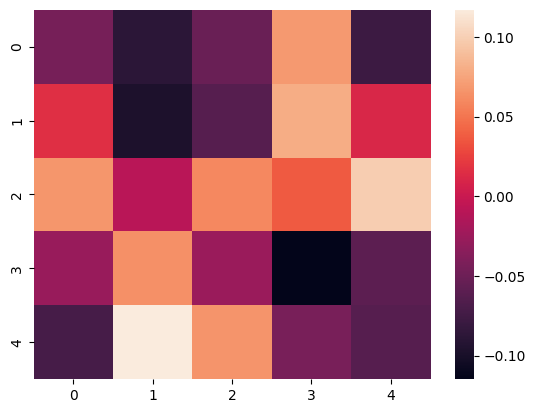

In [38]:
layer = 0
filter = 4
weights, biases = model.layers[layer].get_weights()
print(weights.shape)
sns.heatmap(weights[:,:,0,filter])

## Adverserial attacks
https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa
- Neural networks can sometimes be fooled
- Simple image manipulation can cause mis-classification
  - Structured, invisible noise
  - Carefully placed stickers or tape on objects
  - Drawings of maximum activation patterns
- Can be limited using heavier computations
  - Added noise in image augmentation or weights
  - Train on soft targets (not 0/1)
  - Add adverserial examples in training

## Pipelining
- On-the-fly batch-wise pre-processing 
    - Read from disk
    - Convert to correct format
    - Reshape
    - Augment training set

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            rotation_range=30,
                            vertical_flip=False,
                            horizontal_flip=False)
datagen.fit(X_train_centered)
train_generator = datagen.flow(np.array(X_train_centered), np.array(Y_train), 
                               batch_size=64)
# flow_from_directory for direct import from image files (can include resizing)
# flow_from_dataframe for direct import based on a list of file names (numbering counted alphabetically)

## More augmentations:
https://github.com/albumentations-team/albumentations

### Applying the image generator

In [ ]:
historyFlow = model.fit( # Was called fit_generator in Tensorflow 1.x
    train_generator,
    epochs=10, steps_per_epoch=len(X_train_centered) / 64,
    validation_data=(np.array(X_valid_centered), np.array(Y_valid)), 
    validation_steps=len(X_valid_centered) / 64)

Epoch 1/10
781/781 [==============================] - 93s 118ms/step - loss: 0.6879 - accuracy: 0.7888 - val_loss: 0.0814 - val_accuracy: 0.9755
Epoch 2/10
781/781 [==============================] - 91s 117ms/step - loss: 0.3564 - accuracy: 0.8897 - val_loss: 0.0726 - val_accuracy: 0.9807
Epoch 3/10
781/781 [==============================] - 91s 116ms/step - loss: 0.2770 - accuracy: 0.9146 - val_loss: 0.0584 - val_accuracy: 0.9825
Epoch 4/10
781/781 [==============================] - 92s 118ms/step - loss: 0.2313 - accuracy: 0.9288 - val_loss: 0.0522 - val_accuracy: 0.9851
Epoch 5/10
781/781 [==============================] - 93s 119ms/step - loss: 0.2036 - accuracy: 0.9377 - val_loss: 0.0508 - val_accuracy: 0.9843
Epoch 6/10
781/781 [==============================] - 91s 116ms/step - loss: 0.1860 - accuracy: 0.9424 - val_loss: 0.0454 - val_accuracy: 0.9868
Epoch 7/10
781/781 [==============================] - 89s 114ms/step - loss: 0.1704 - accuracy: 0.9469 - val_loss: 0.0429 - val_ac

## Softmax activation
$$\sigma (a)_i = \frac{e^{a_i}}{\sum_{j=1}^K e^{a_j}} = h_i$$
- The activation of class $i$
- Exponent of each dummy input divided by the sum of exponents of all dummy inputs
  - Class activations sum to 1
- Only for output layer of a model

In [ ]:
import tensorflow as tf
def round_tensor(x, dec):
    return np.round(tf.make_ndarray(tf.make_tensor_proto(x)), dec)

a = tf.constant([[-5, 0, 5, 6], [10, 0, 5, 6]], dtype=tf.float32)
b = tf.keras.activations.softmax(a)
round_tensor(b, 2)

array([[0.  , 0.  , 0.27, 0.73],
       [0.98, 0.  , 0.01, 0.02]], dtype=float32)

## ReLU activation
$\sigma(x) = max(0, x)$

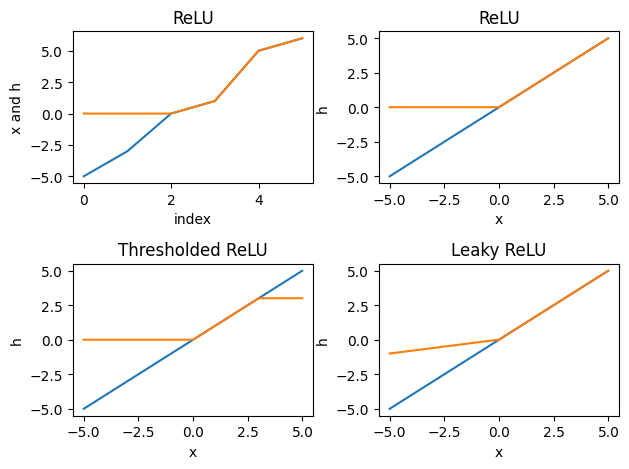

In [ ]:
import matplotlib.pyplot as plt
x = tf.constant([-5, -3, 0, 1, 5, 6], dtype=tf.float32)
z = tf.constant(tf.range(-5,5, 0.01))
a = tf.keras.activations.relu(x); b = tf.keras.activations.relu(z) 
d = tf.keras.activations.relu(z, 0, 3) # Thresholded
e = tf.keras.activations.relu(z, 0.2)  # Leaky
plt.subplot(2, 2, 1); plt.plot(x); plt.plot(round_tensor(a, 3)); plt.xlabel('index'); plt.ylabel('x and h'); plt.title('ReLU')
plt.subplot(2, 2, 2); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(b, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('ReLU')
plt.subplot(2, 2, 3); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(d, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('Thresholded ReLU')
plt.subplot(2, 2, 4); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(e, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('Leaky ReLU')
plt.tight_layout(); plt.show()

## Swish activation
$\sigma(x) = x \cdot sigmoid(x) = \frac{x}{1+e^{-x}}$

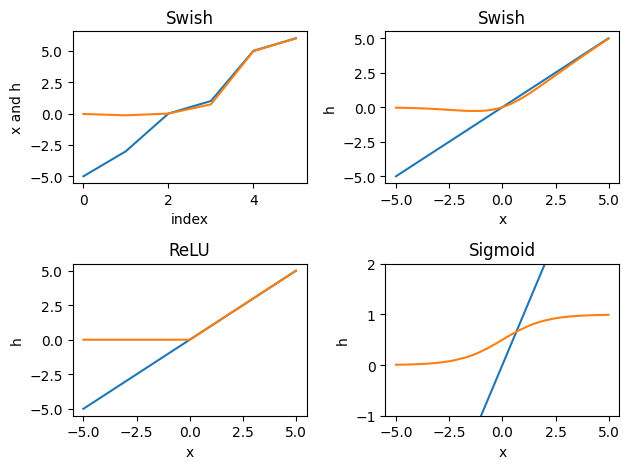

In [ ]:
x = tf.constant([-5, -3, 0, 1, 5, 6], dtype=tf.float32)
z = tf.constant(tf.range(-5,5, 0.01))
a = tf.keras.activations.swish(x)
c = tf.keras.activations.swish(z)
f = tf.keras.activations.sigmoid(z)
plt.subplot(2, 2, 1); plt.plot(x); plt.plot(round_tensor(a, 3)); plt.xlabel('index'); plt.ylabel('x and h'); plt.title('Swish')
plt.subplot(2, 2, 2); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(c, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('Swish')
plt.subplot(2, 2, 3); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(b, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('ReLU')
plt.subplot(2, 2, 4); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(f, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('Sigmoid'); plt.ylim([-1,2])
plt.tight_layout(); plt.show()